In [1]:
import pandas as pd

from oversampling_training.oversampling_multiclass import split_dataset, apply_smote_multiclass, train_random_forest_multiclass, train_svm_multiclass, train_lightgbm, rf_plot_confusion_matrices, svm_plot_confusion_matrices, lightgbm_plot_confusion_matrices
from features_extraction import features, exp1, exp2
from preprocessing.resample import resample_dataset

# CLASSIFICAZIONE MULTICLASSE

In [2]:
csv_file_path = 'C:/underwater-classification/resample_experiments/resampling_44100/binary/Malfante_resampled_44100_binary.csv'

### Resampling a 44100

In [3]:
resample_dataset(csv_file_path, 44100)

In [4]:
# Carica il file CSV in un DataFrame
#df = extract_features_from_directory(csv_file_path)

In [5]:
df = pd.read_csv(csv_file_path)

In [6]:
df.to_csv("Malfante_resampled_44100_multi.csv", index=False)

In [7]:
print("Distribuzione delle subclass prima dello split:")
print(df['Subclass'].value_counts())

Distribuzione delle subclass prima dello split:
Subclass
Passengership                 11728
Tanker                        11221
Tug                           10162
Cargo                          9671
Humpback Whale                 1523
                              ...  
Northern bottlenose whale         2
Australian Snubfin Dolphin        1
Pygmy Right Whale                 1
True_s beaked whale               1
Harbor porpoise                   1
Name: count, Length: 112, dtype: int64


In [8]:
df

,File Name,Class,Subclass,Spectral Centroid Mean,Spectral Bandwidth RMS,Standard Deviation,Skewness,Kurtosis,Shannon Entropy,Renyi Entropy,Rate of Attack,Rate of Decay,Threshold Crossings,Silence Ratio,Mean,Max Over Mean,Min Over Mean,Energy Measurements
0,0f9867d8-fcf7-40d1-b846-3f7fb8100eb7_seg1.wav,Non-Target,Ambient Noise,2814.810139,3623.732736,0.226857,0.290667,0.892109,4.973875,-5.538038,169.092308,0.008137,4344,0.611757,-0.034168,-21.401657,23.592554,0.052632
1,0f9867d8-fcf7-40d1-b846-3f7fb8100eb7_seg2.wav,Non-Target,Ambient Noise,3249.861847,3805.262450,0.108625,-0.005667,-0.569433,5.162824,-6.900361,159.187500,0.008056,4652,0.634756,-0.032938,-9.474487,10.161032,0.012884
2,0f9867d8-fcf7-40d1-b846-3f7fb8100eb7_seg3.wav,Non-Target,Ambient Noise,2621.295333,3576.628987,0.247894,-0.276422,0.685542,4.946384,-5.217734,171.703125,0.008095,2650,0.577143,-0.030707,-25.081358,32.558956,0.062394
3,0f9867d8-fcf7-40d1-b846-3f7fb8100eb7_seg4.wav,Non-Target,Ambient Noise,3058.706239,3745.924108,0.156887,0.579543,1.394187,4.977184,-6.244905,171.128205,0.008055,3648,0.676684,-0.033139,-17.870926,14.267456,0.025712
4,0f9867d8-fcf7-40d1-b846-3f7fb8100eb7_seg5.wav,Non-Target,Ambient Noise,2903.128537,3701.644532,0.182234,-0.088014,-0.083022,5.107663,-5.868163,164.875000,0.008143,3886,0.587954,-0.031096,-16.127235,20.705437,0.034176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50988,ship_small_seg5.wav,Target,Vessel,480.625127,548.006873,0.194803,0.013838,0.040818,4.912233,-5.506029,174.620253,0.009097,3257,0.502557,0.010883,67.246010,-71.797320,0.038067
50989,ship_small_seg6.wav,Target,Vessel,482.119528,558.672946,0.187102,0.015868,0.072814,4.923558,-5.597483,173.717949,0.008768,3284,0.499932,0.010365,68.939610,-69.740450,0.035115
50990,ship_small_seg7.wav,Target,Vessel,476.431546,548.728008,0.179071,0.000760,0.094909,4.904596,-5.671142,174.620253,0.008328,3247,0.500601,0.011134,60.327410,-65.529655,0.032190
50991,ship_small_seg8.wav,Target,Vessel,478.236515,546.012770,0.188441,-0.002945,0.136699,4.846771,-5.513667,172.924051,0.008789,3283,0.495748,0.010449,76.978740,-72.533554,0.035619


### Filtro dataframe

In [9]:
df['File Name'] = df['File Name'].str[:-4]
df = df[df['Class'] == 'Target'].copy()
# Aggiungi una colonna "Parent" che contiene il prefisso dei file per garantire la coesione dei segmenti
df['Parent'] = df['File Name'].str.extract(r'^(.*?)(?=_seg)')

# Filtra le subclass con almeno 10 parent distinti
parent_counts = df.groupby('Subclass')['Parent'].nunique()
subclasses_to_keep = parent_counts[parent_counts >= 10].index
df = df[df['Subclass'].isin(subclasses_to_keep)].copy()

print(f"Dimensione totale dopo il filtraggio: {df.shape[0]} campioni")

Dimensione totale dopo il filtraggio: 43089 campioni


## SPLIT

In [10]:
X_train_imputed, X_val_imputed, X_test_imputed, y_train_encoded, y_val_encoded, y_test_encoded, subclass_encoder = split_dataset(df)


Dimensione del set di addestramento: 33872 campioni (78.61%)
Dimensione del set di validazione: 4403 campioni (10.22%)
Dimensione del set di test: 4814 campioni (11.17%)

Distribuzione delle subclass nel set di addestramento:
Subclass
Passengership    8830
Tanker           8744
Tug              8213
Cargo            7802
Vessel            283
Name: count, dtype: int64

Distribuzione delle subclass nel set di validazione:
Subclass
Passengership    1291
Tanker           1276
Tug               956
Cargo             862
Vessel             18
Name: count, dtype: int64

Distribuzione delle subclass nel set di test:
Subclass
Passengership    1607
Tanker           1201
Cargo            1007
Tug               993
Vessel              6
Name: count, dtype: int64


In [11]:
X_train_imputed[['File Name', 'Parent', 'Subclass']].groupby(['Parent', 'File Name']).describe()

Subclass  \
                                                                                   count   
Parent                               File Name                                             
1cc5583b-fe72-4cb2-b64c-563bd87ad91b 1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg1         1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg10        1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg11        1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg12        1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg13        1   
...                                                                                  ...   
ship_small                           ship_small_seg5                                   1   
                                     ship_small_seg6                                   1   
                                     ship_small_seg7                                   1   
                                     ship_small_seg8                                   1   
                                     ship_small_seg9                                   1   

                                                                                        \
                                                                                unique   
Parent                               File Name                                           
1cc5583b-fe72-4cb2-b64c-563bd87ad91b 1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg1       1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg10      1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg11      1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg12      1   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg13      1   
...                                                                                ...   
ship_small                           ship_small_seg5                                 1   
                                     ship_small_seg6                                 1   
                                     ship_small_seg7                                 1   
                                     ship_small_seg8                                 1   
                                     ship_small_seg9                                 1   

                                                                                                \
                                                                                           top   
Parent                               File Name                                                   
1cc5583b-fe72-4cb2-b64c-563bd87ad91b 1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg1   Passengership   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg10  Passengership   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg11  Passengership   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg12  Passengership   
                                     1cc5583b-fe72-4cb2-b64c-563bd87ad91b_seg13  Passengership   
...                                                                                        ...   
ship_small                           ship_small_seg5                                    Vessel   
                                     ship_small_seg6                                    Vessel   
                                     ship_small_seg7                                    Vessel   
                                     ship_small_seg8                                    Vessel   
                                     ship_small_seg9                                    Vessel   

                                                                                      
                                                                      

In [12]:
X_test_imputed[['File Name', 'Parent','Subclass']].groupby(['Parent', 'File Name']).describe()

Subclass  \
                                                                                                    count   
Parent                                        File Name                                                     
20160516a-9_9                                 20160516a-9_9_seg1                                        1   
                                              20160516a-9_9_seg2                                        1   
                                              20160516a-9_9_seg3                                        1   
20160616b-21_200904                           20160616b-21_200904_seg1                                  1   
                                              20160616b-21_200904_seg10                                 1   
...                                                                                                   ...   
SanctSound_GR01_01_vessel_20181217T204109Z    SanctSound_GR01_01_vessel_20181217T204109Z_seg2           1   
SanctSound_HI04_02_smallboat_20191211T175807Z SanctSound_HI04_02_smallboat_20191211T175807Z_seg1        1   
                                              SanctSound_HI04_02_smallboat_20191211T175807Z_seg2        1   
SanctSound_SB03_09_vessel_20200415T161235Z    SanctSound_SB03_09_vessel_20200415T161235Z_seg1           1   
                                              SanctSound_SB03_09_vessel_20200415T161235Z_seg2           1   

                                                                                                         \
                                                                                                 unique   
Parent                                        File Name                                                   
20160516a-9_9                                 20160516a-9_9_seg1                                      1   
                                              20160516a-9_9_seg2                                      1   
                                              20160516a-9_9_seg3                                      1   
20160616b-21_200904                           20160616b-21_200904_seg1                                1   
                                              20160616b-21_200904_seg10                               1   
...                                                                                                 ...   
SanctSound_GR01_01_vessel_20181217T204109Z    SanctSound_GR01_01_vessel_20181217T204109Z_seg2         1   
SanctSound_HI04_02_smallboat_20191211T175807Z SanctSound_HI04_02_smallboat_20191211T175807Z_seg1      1   
                                              SanctSound_HI04_02_smallboat_20191211T175807Z_seg2      1   
SanctSound_SB03_09_vessel_20200415T161235Z    SanctSound_SB03_09_vessel_20200415T161235Z_seg1         1   
                                              SanctSound_SB03_09_vessel_20200415T161235Z_seg2         1   

                                                                                                                 \
                                                                                                            top   
Parent                                        File Name                                                           
20160516a-9_9                                 20160516a-9_9_seg1                                  Passengership   
                                              20160516a-9_9_seg2                                  Passengership   
                                              20160516a-9_9_seg3                                  Passengership   
20160616b-21_200904                           20160616b-21_200904_seg1                            Passengership   
                                              20160616b-21_200904_seg10                           Passengership   
...                                                                                                         ...   
SanctSound_GR01_01_vessel_20181217T2

In [13]:
X_val_imputed[['File Name', 'Parent','Subclass']].groupby(['Parent', 'File Name']).describe()


Subclass  \
                                                                                          count   
Parent                                   File Name                                                
20160531-7_142749                        20160531-7_142749_seg1                               1   
                                         20160531-7_142749_seg10                              1   
                                         20160531-7_142749_seg100                             1   
                                         20160531-7_142749_seg101                             1   
                                         20160531-7_142749_seg102                             1   
...                                                                                         ...   
SanctSound_OC02_01_ship_20190419T233040Z SanctSound_OC02_01_ship_20190419T233040Z_seg5        1   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg6        1   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg7        1   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg8        1   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg9        1   

                                                                                               \
                                                                                       unique   
Parent                                   File Name                                              
20160531-7_142749                        20160531-7_142749_seg1                             1   
                                         20160531-7_142749_seg10                            1   
                                         20160531-7_142749_seg100                           1   
                                         20160531-7_142749_seg101                           1   
                                         20160531-7_142749_seg102                           1   
...                                                                                       ...   
SanctSound_OC02_01_ship_20190419T233040Z SanctSound_OC02_01_ship_20190419T233040Z_seg5      1   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg6      1   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg7      1   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg8      1   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg9      1   

                                                                                                \
                                                                                           top   
Parent                                   File Name                                               
20160531-7_142749                        20160531-7_142749_seg1                         Tanker   
                                         20160531-7_142749_seg10                        Tanker   
                                         20160531-7_142749_seg100                       Tanker   
                                         20160531-7_142749_seg101                       Tanker   
                                         20160531-7_142749_seg102                       Tanker   
...                                                                                        ...   
SanctSound_OC02_01_ship_20190419T233040Z SanctSound_OC02_01_ship_20190419T233040Z_seg5  Vessel   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg6  Vessel   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg7  Vessel   
                                         SanctSound_OC02_01_ship_20190419T233040Z_seg8  Vessel   
                                         SanctSound_OC02_01_ship_20

## SMOTE

In [14]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # Adatta questo valore al numero di core che desideri utilizzare

In [15]:
X_train_resampled, y_train_resampled = apply_smote_multiclass(X_train_imputed, y_train_encoded, 1)

Distribuzione delle classi nel set di training dopo SMOTE:
1    8830
2    8830
0    8830
3    8830
4    8830
Name: count, dtype: int64


In [16]:
print(pd.Series(subclass_encoder.inverse_transform(y_train_resampled)).value_counts())

Passengership    8830
Tanker           8830
Cargo            8830
Tug              8830
Vessel           8830
Name: count, dtype: int64


In [17]:
print(f"\nDistribuzione delle classi nel set di validation:\n \n{pd.Series(y_val_encoded).value_counts()} ")


Distribuzione delle classi nel set di validation:
 
1    1291
2    1276
3     956
0     862
4      18
Name: count, dtype: int64 


In [18]:

print(f"\nDistribuzione delle classi nel set di test:\n \n{pd.Series(y_test_encoded).value_counts()} ")


Distribuzione delle classi nel set di test:
 
1    1607
2    1201
0    1007
3     993
4       6
Name: count, dtype: int64 


In [19]:
# Stampare le forme dei dataset
print("\nForme dei dataset:")
print(f"Train: {X_train_imputed.shape}") #validation
print(f"Validation: {X_val_imputed.shape}") #validation
print(f"Test: {X_test_imputed.shape}") #test
print(f"Train bilanciato e filtrato: {X_train_resampled.shape}") #train dopo SMOTE


Forme dei dataset:
Train: (33872, 19)
Validation: (4403, 19)
Test: (4814, 19)
Train bilanciato e filtrato: (44150, 15)


# Esperimento 1 

Esperimento effettuato prendendo come riferimento alcune features numeriche da "Malfante et al."

In [20]:
# Rimuovi le colonne non necessarie per evitare errori nei nomi delle feature
X_val_imputed = X_val_imputed.drop(columns=["Class", "File Name", "Parent", "Subclass"], errors='ignore')
X_test_imputed = X_test_imputed.drop(columns=["Class", "File Name", "Parent", "Subclass"], errors='ignore')


### 1.1 Random Forest Model

In [21]:
random_forest_model = train_random_forest_multiclass(X_train_resampled, y_train_resampled, X_val_imputed, y_val_encoded, X_test_imputed, y_test_encoded)

Accuratezza sul Validation Set: 0.4113
Log Loss sul Validation Set: 1.3606

=== Report di Classificazione - Validation Set ===
              precision    recall  f1-score   support

           0       0.27      0.37      0.31       862
           1       0.51      0.30      0.38      1291
           2       0.45      0.43      0.44      1276
           3       0.44      0.57      0.50       956
           4       0.50      1.00      0.67        18

    accuracy                           0.41      4403
   macro avg       0.44      0.53      0.46      4403
weighted avg       0.43      0.41      0.41      4403

Accuratezza sul Test Set: 0.4283
Log Loss sul Test Set: 1.3070

=== Report di Classificazione - Test Set ===
              precision    recall  f1-score   support

           0       0.41      0.43      0.42      1007
           1       0.41      0.23      0.30      1607
           2       0.46      0.48      0.47      1201
           3       0.44      0.69      0.54       993
    

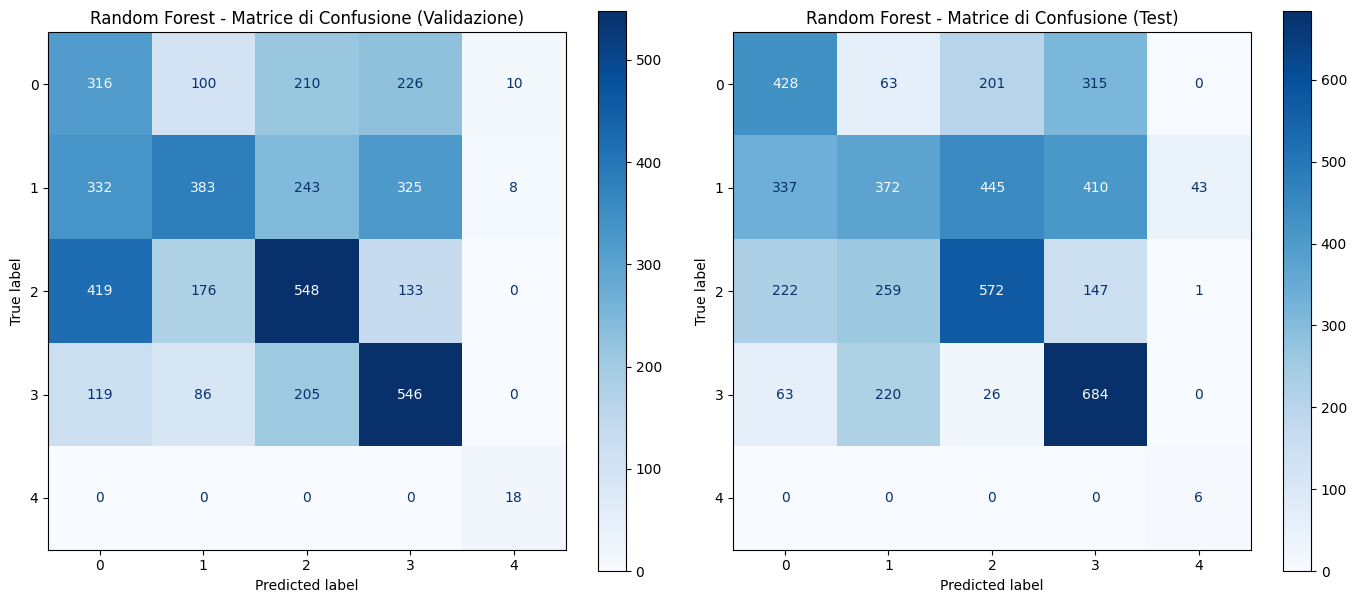

In [22]:
rf_plot_confusion_matrices(random_forest_model, X_val_imputed, y_val_encoded, X_test_imputed, y_test_encoded)


### 1.2 SVM Model

In [23]:
svm_model = train_svm_multiclass(X_train_resampled, y_train_resampled, X_val_imputed, y_val_encoded, X_test_imputed, y_test_encoded)

Distribuzione delle classi reali nel set di validazione: [ 862 1291 1276  956   18]
Distribuzione delle classi predette nel set di validazione: [1527  501  330 1976   69]
Report di classificazione del set di validazione:
              precision    recall  f1-score   support

           0       0.15      0.27      0.20       862
           1       0.38      0.15      0.21      1291
           2       0.54      0.14      0.22      1276
           3       0.19      0.38      0.25       956
           4       0.26      1.00      0.41        18

    accuracy                           0.22      4403
   macro avg       0.30      0.39      0.26      4403
weighted avg       0.34      0.22      0.22      4403

Accuratezza sul set di validazione: 0.2246
Distribuzione delle classi reali nel set di test: [1007 1607 1201  993    6]
Distribuzione delle classi predette nel set di test: [1586  828  438 1861  101]
Report di classificazione del set di test:
              precision    recall  f1-score   s

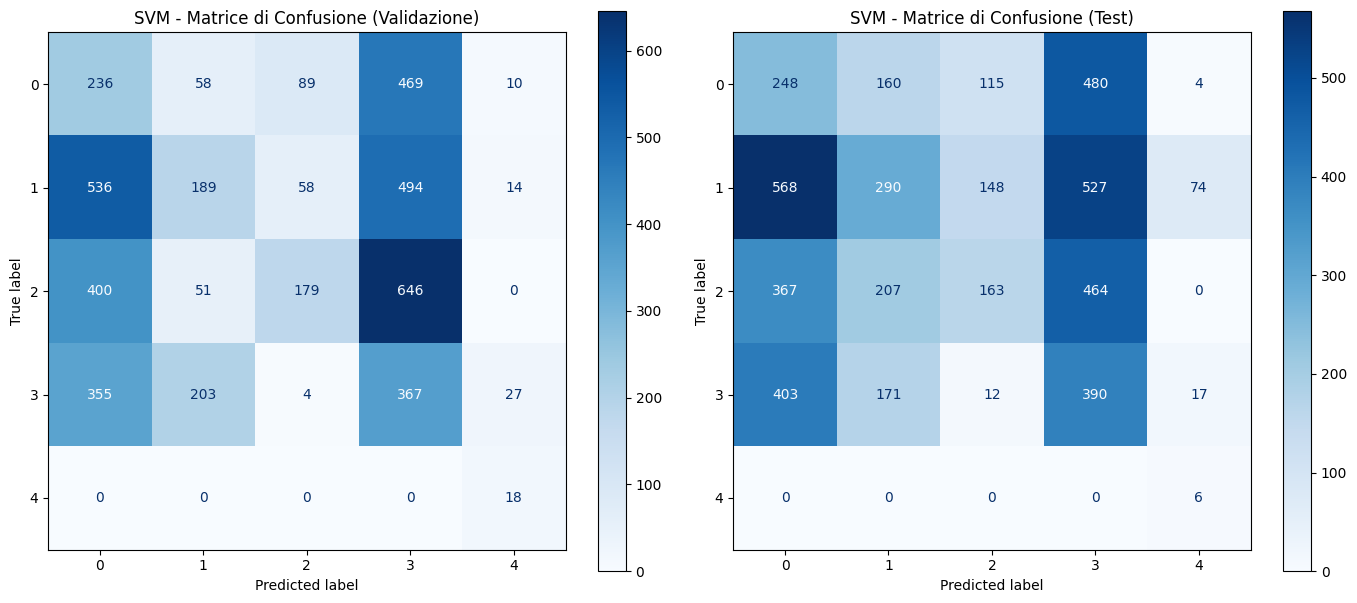

In [24]:
svm_plot_confusion_matrices(svm_model, X_val_imputed, y_val_encoded, X_test_imputed, y_test_encoded)

### 1.3 LightGBM Model

In [25]:
lightgbm_model = train_lightgbm(X_train_resampled, y_train_resampled, X_val_imputed, y_val_encoded, X_test_imputed, y_test_encoded)

Dimensioni dopo NaN nel set di addestramento: X_train: (44150, 15), y_train: (44150,)
Dimensioni dopo NaN nel set di validazione: X_val: (4403, 15), y_val: (4403,)
Dimensioni dopo NaN nel set di test: X_test: (4814, 15), y_test: (4814,)
Classi nel set di addestramento: [0 1 2 3 4]
Classi nel set di validazione: [0 1 2 3 4]
Classi nel set di test: [0 1 2 3 4]
Report di classificazione del set di validazione:
              precision    recall  f1-score   support

           0       0.22      0.29      0.25       862
           1       0.45      0.35      0.39      1291
           2       0.38      0.40      0.39      1276
           3       0.55      0.51      0.53       956
           4       0.50      1.00      0.67        18

    accuracy                           0.39      4403
   macro avg       0.42      0.51      0.45      4403
weighted avg       0.41      0.39      0.39      4403

Accuratezza sul set di validazione: 0.3891
Report di classificazione del set di test:
              

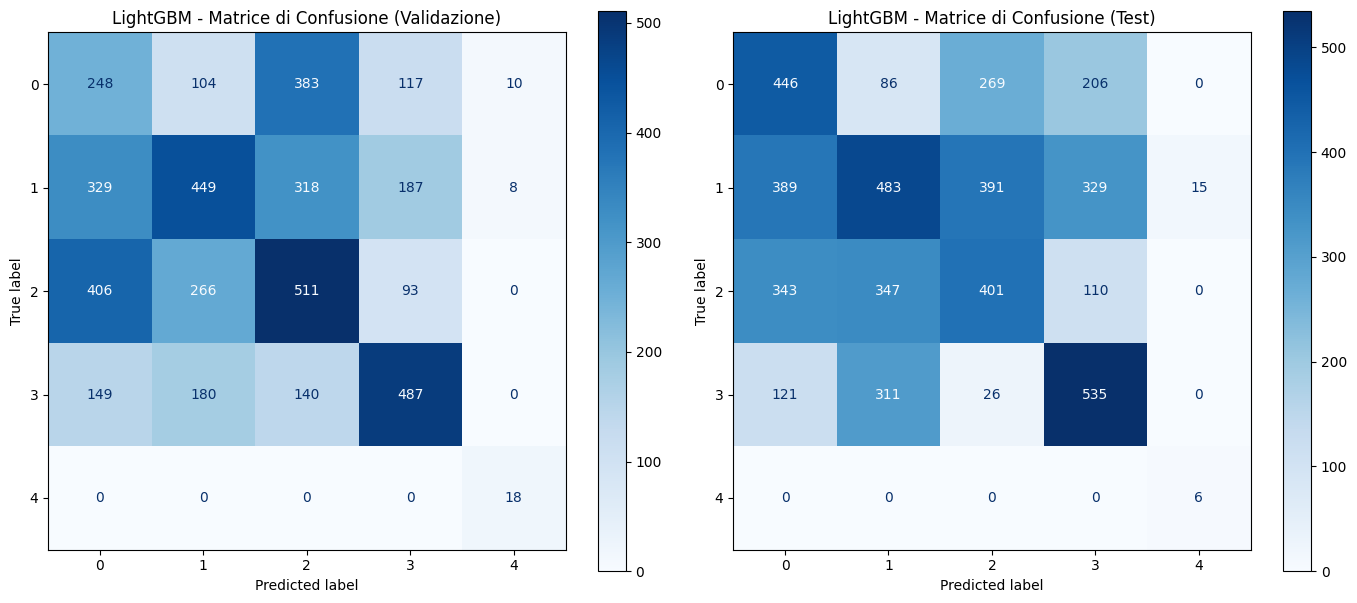

In [26]:
lightgbm_plot_confusion_matrices(lightgbm_model, X_val_imputed, y_val_encoded, X_test_imputed, y_test_encoded)

## Esperimento 2

Esperimento effettuato prendendo come riferimento alcune features numeriche da “BirdNet”

In [27]:
csv_file_path_exp1 = 'C:/underwater-classification/resample_experiments/resampling_44100/binary/BirdNet_resampled_44100_binary.csv'


In [28]:
resample_dataset(csv_file_path_exp1, 44100)

In [29]:
#df_exp1 = exp1.extract_features_from_directory(csv_file_path_exp1)

In [30]:
#df_exp1.to_csv("BirdNet_resampled_44100_multi.csv", index=False)

In [31]:
df_exp1 = pd.read_csv(csv_file_path_exp1)

In [32]:
df_exp1['File Name'] = df_exp1['File Name'].str[:-4]
df_exp1 = df_exp1[df_exp1['Class'] == 'Target'].copy()
# Aggiungi una colonna "Parent" che contiene il prefisso dei file per garantire la coesione dei segmenti
df_exp1['Parent'] = df_exp1['File Name'].str.extract(r'^(.*?)(?=_seg)')

# Filtra le subclass con almeno 10 parent distinti
parent_counts = df_exp1.groupby('Subclass')['Parent'].nunique()
subclasses_to_keep = parent_counts[parent_counts >= 10].index
df_exp1 = df_exp1[df_exp1['Subclass'].isin(subclasses_to_keep)].copy()

print(f"Dimensione totale dopo il filtraggio: {df_exp1.shape[0]} campioni")

Dimensione totale dopo il filtraggio: 43089 campioni


In [33]:
X_train_imputed_exp1, X_val_imputed_exp1, X_test_imputed_exp1, y_train_encoded_exp1, y_val_encoded_exp1, y_test_encoded_exp1, subclass_encoder_exp1 = split_dataset(df_exp1)
X_train_resampled_exp1, y_train_resampled_exp1 = apply_smote_multiclass(X_train_imputed_exp1, y_train_encoded_exp1, 1)


Dimensione del set di addestramento: 33872 campioni (78.61%)
Dimensione del set di validazione: 4403 campioni (10.22%)
Dimensione del set di test: 4814 campioni (11.17%)

Distribuzione delle subclass nel set di addestramento:
Subclass
Passengership    8830
Tanker           8744
Tug              8213
Cargo            7802
Vessel            283
Name: count, dtype: int64

Distribuzione delle subclass nel set di validazione:
Subclass
Passengership    1291
Tanker           1276
Tug               956
Cargo             862
Vessel             18
Name: count, dtype: int64

Distribuzione delle subclass nel set di test:
Subclass
Passengership    1607
Tanker           1201
Cargo            1007
Tug               993
Vessel              6
Name: count, dtype: int64
Distribuzione delle classi nel set di training dopo SMOTE:
1    8830
2    8830
0    8830
3    8830
4    8830
Name: count, dtype: int64


In [34]:
# Rimuovi le colonne non necessarie per evitare errori nei nomi delle feature
X_val_imputed_exp1 = X_val_imputed_exp1.drop(columns=["Class", "File Name", "Parent", "Subclass"], errors='ignore')
X_test_imputed_exp1 = X_test_imputed_exp1.drop(columns=["Class", "File Name", "Parent", "Subclass"], errors='ignore')

### 2.1 Random Forest Model

In [35]:
random_forest_model_exp1 = train_random_forest_multiclass(X_train_resampled_exp1, y_train_resampled_exp1, X_val_imputed_exp1, y_val_encoded_exp1, X_test_imputed_exp1, y_test_encoded_exp1)

Accuratezza sul Validation Set: 0.5816
Log Loss sul Validation Set: 1.1053

=== Report di Classificazione - Validation Set ===
              precision    recall  f1-score   support

           0       0.47      0.53      0.50       862
           1       0.60      0.51      0.55      1291
           2       0.62      0.72      0.67      1276
           3       0.62      0.53      0.57       956
           4       0.50      1.00      0.67        18

    accuracy                           0.58      4403
   macro avg       0.56      0.66      0.59      4403
weighted avg       0.59      0.58      0.58      4403

Accuratezza sul Test Set: 0.4877
Log Loss sul Test Set: 1.1351

=== Report di Classificazione - Test Set ===
              precision    recall  f1-score   support

           0       0.53      0.35      0.42      1007
           1       0.44      0.41      0.42      1607
           2       0.57      0.51      0.54      1201
           3       0.46      0.72      0.56       993
    

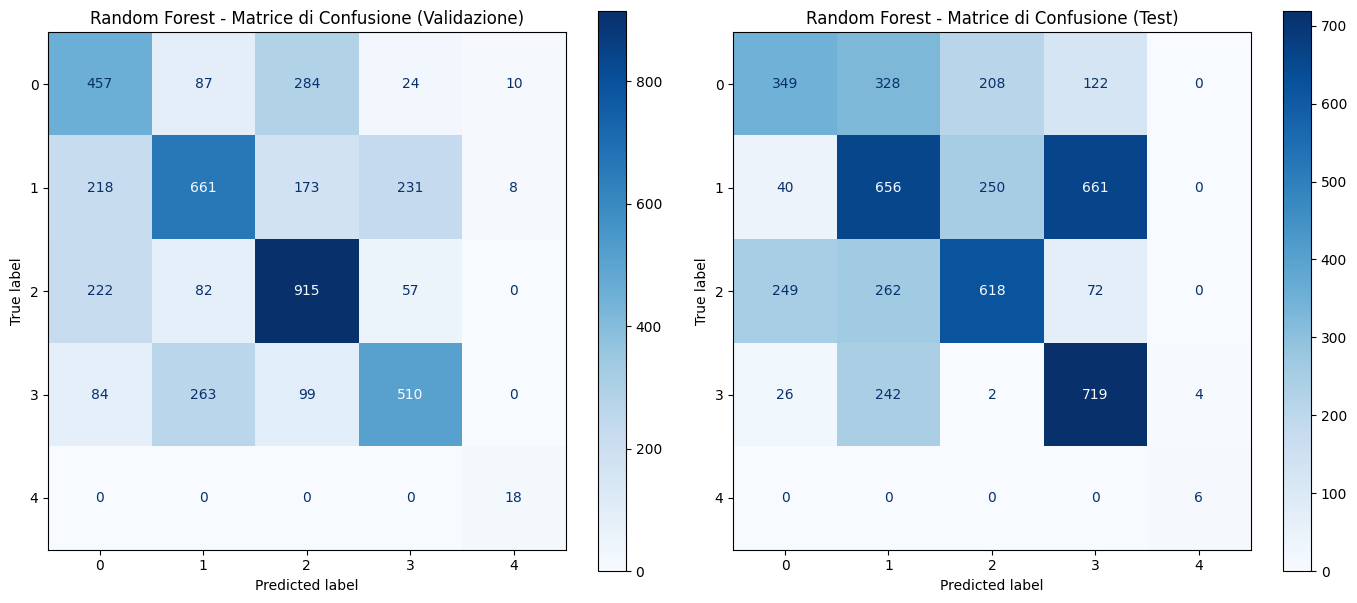

In [36]:
rf_plot_confusion_matrices(random_forest_model_exp1, X_val_imputed_exp1, y_val_encoded_exp1, X_test_imputed_exp1, y_test_encoded_exp1)

### 2.2 SVM Model

In [37]:
svm_model_exp1 = train_svm_multiclass(X_train_resampled_exp1, y_train_resampled_exp1, X_val_imputed_exp1, y_val_encoded_exp1, X_test_imputed_exp1, y_test_encoded_exp1)

Distribuzione delle classi reali nel set di validazione: [ 862 1291 1276  956   18]
Distribuzione delle classi predette nel set di validazione: [1053  635  955 1728   32]
Report di classificazione del set di validazione:
              precision    recall  f1-score   support

           0       0.22      0.27      0.25       862
           1       0.39      0.19      0.26      1291
           2       0.54      0.41      0.47      1276
           3       0.38      0.68      0.49       956
           4       0.09      0.17      0.12        18

    accuracy                           0.38      4403
   macro avg       0.33      0.34      0.32      4403
weighted avg       0.40      0.38      0.37      4403

Accuratezza sul set di validazione: 0.3770
Distribuzione delle classi reali nel set di test: [1007 1607 1201  993    6]
Distribuzione delle classi predette nel set di test: [1037 1044 1149 1507   77]
Report di classificazione del set di test:
              precision    recall  f1-score   s

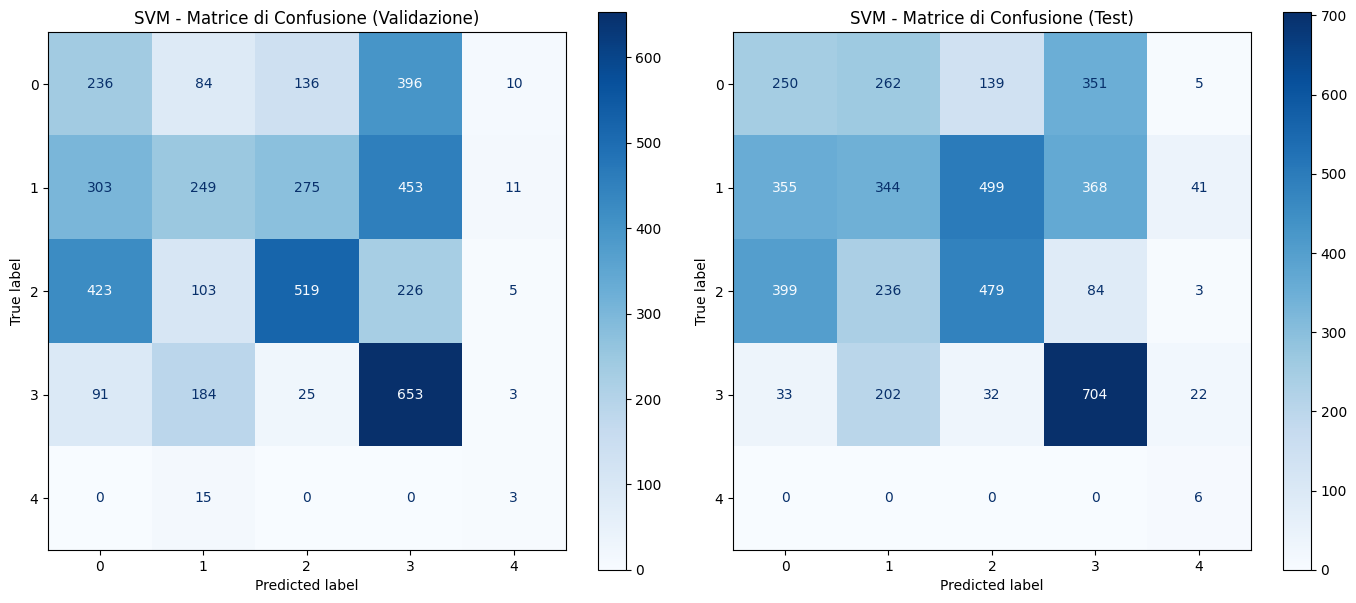

In [38]:
svm_plot_confusion_matrices(svm_model_exp1, X_val_imputed_exp1, y_val_encoded_exp1, X_test_imputed_exp1, y_test_encoded_exp1)

### 2.3 LightGBM Model

In [39]:
lightgbm_model_exp1 = train_lightgbm(X_train_resampled_exp1, y_train_resampled_exp1, X_val_imputed_exp1, y_val_encoded_exp1, X_test_imputed_exp1, y_test_encoded_exp1)

Dimensioni dopo NaN nel set di addestramento: X_train: (44150, 28), y_train: (44150,)
Dimensioni dopo NaN nel set di validazione: X_val: (4403, 28), y_val: (4403,)
Dimensioni dopo NaN nel set di test: X_test: (4814, 28), y_test: (4814,)
Classi nel set di addestramento: [0 1 2 3 4]
Classi nel set di validazione: [0 1 2 3 4]
Classi nel set di test: [0 1 2 3 4]
Report di classificazione del set di validazione:
              precision    recall  f1-score   support

           0       0.44      0.52      0.48       862
           1       0.50      0.45      0.47      1291
           2       0.56      0.64      0.60      1276
           3       0.69      0.51      0.58       956
           4       0.75      1.00      0.86        18

    accuracy                           0.54      4403
   macro avg       0.59      0.63      0.60      4403
weighted avg       0.55      0.54      0.54      4403

Accuratezza sul set di validazione: 0.5358
Report di classificazione del set di test:
              

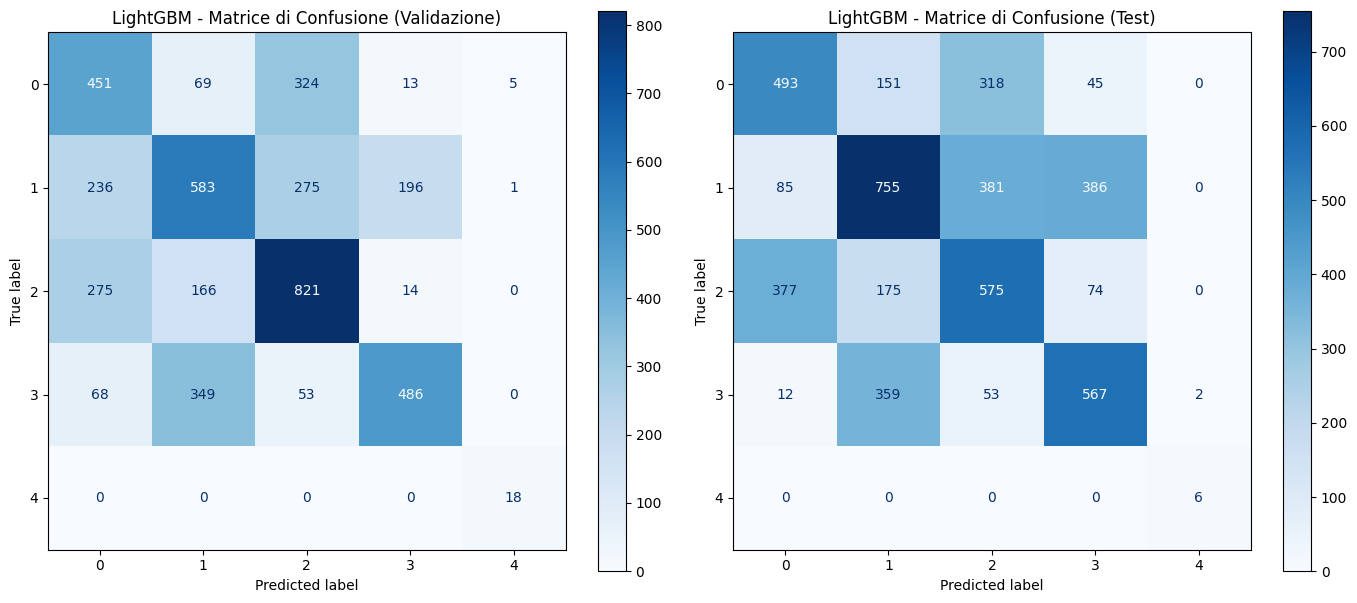

In [40]:
lightgbm_plot_confusion_matrices(lightgbm_model_exp1, X_val_imputed_exp1, y_val_encoded_exp1, X_test_imputed_exp1, y_test_encoded_exp1)

## Esperimento 3

Esperimento effettuato prendendo come riferimento features numeriche da "A Survey on Audio Feature Extraction for Automatic Music Genre Classification" di Dhamodaran et al.

In [41]:
csv_file_path_exp2 = 'C:/underwater-classification/resample_experiments/resampling_44100/binary/Malfante_resampled_44100_binary.csv'

In [42]:
resample_dataset(csv_file_path_exp2, 44100)

In [43]:
#df_exp2 = exp2.extract_features_from_directory(csv_file_path_exp2)

In [44]:
df_exp2 = pd.read_csv(csv_file_path_exp1)

In [45]:
df_exp2.to_csv("Dhamodaran_resampled_44100_multi.csv", index=False)

In [46]:
df_exp2['File Name'] = df_exp2['File Name'].str[:-4]
df_exp2 = df_exp2[df_exp2['Class'] == 'Target'].copy()
# Aggiungi una colonna "Parent" che contiene il prefisso dei file per garantire la coesione dei segmenti
df_exp2['Parent'] = df_exp2['File Name'].str.extract(r'^(.*?)(?=_seg)')

# Filtra le subclass con almeno 10 parent distinti
parent_counts = df_exp2.groupby('Subclass')['Parent'].nunique()
subclasses_to_keep = parent_counts[parent_counts >= 10].index
df_exp2 = df_exp2[df_exp2['Subclass'].isin(subclasses_to_keep)].copy()

print(f"Dimensione totale dopo il filtraggio: {df_exp2.shape[0]} campioni")

Dimensione totale dopo il filtraggio: 43089 campioni


In [47]:
X_train_imputed_exp2, X_val_imputed_exp2, X_test_imputed_exp2, y_train_encoded_exp2, y_val_encoded_exp2, y_test_encoded_exp2, subclass_encoder_exp2 = split_dataset(df_exp2)
X_train_resampled_exp2, y_train_resampled_exp2 = apply_smote_multiclass(X_train_imputed_exp2, y_train_encoded_exp2, 1)

# Rimuovi le colonne non necessarie per evitare errori nei nomi delle feature
X_val_imputed_exp2 = X_val_imputed_exp2.drop(columns=["Class", "File Name", "Parent", "Subclass"], errors='ignore')
X_test_imputed_exp2 = X_test_imputed_exp2.drop(columns=["Class", "File Name", "Parent", "Subclass"], errors='ignore')


Dimensione del set di addestramento: 33872 campioni (78.61%)
Dimensione del set di validazione: 4403 campioni (10.22%)
Dimensione del set di test: 4814 campioni (11.17%)

Distribuzione delle subclass nel set di addestramento:
Subclass
Passengership    8830
Tanker           8744
Tug              8213
Cargo            7802
Vessel            283
Name: count, dtype: int64

Distribuzione delle subclass nel set di validazione:
Subclass
Passengership    1291
Tanker           1276
Tug               956
Cargo             862
Vessel             18
Name: count, dtype: int64

Distribuzione delle subclass nel set di test:
Subclass
Passengership    1607
Tanker           1201
Cargo            1007
Tug               993
Vessel              6
Name: count, dtype: int64
Distribuzione delle classi nel set di training dopo SMOTE:
1    8830
2    8830
0    8830
3    8830
4    8830
Name: count, dtype: int64


### 3.1 Random Forest Model

In [48]:
random_forest_model_exp2 = train_random_forest_multiclass(X_train_resampled_exp2, y_train_resampled_exp2, X_val_imputed_exp2, y_val_encoded_exp2, X_test_imputed_exp2, y_test_encoded_exp2)

Accuratezza sul Validation Set: 0.5816
Log Loss sul Validation Set: 1.1053

=== Report di Classificazione - Validation Set ===
              precision    recall  f1-score   support

           0       0.47      0.53      0.50       862
           1       0.60      0.51      0.55      1291
           2       0.62      0.72      0.67      1276
           3       0.62      0.53      0.57       956
           4       0.50      1.00      0.67        18

    accuracy                           0.58      4403
   macro avg       0.56      0.66      0.59      4403
weighted avg       0.59      0.58      0.58      4403

Accuratezza sul Test Set: 0.4877
Log Loss sul Test Set: 1.1351

=== Report di Classificazione - Test Set ===
              precision    recall  f1-score   support

           0       0.53      0.35      0.42      1007
           1       0.44      0.41      0.42      1607
           2       0.57      0.51      0.54      1201
           3       0.46      0.72      0.56       993
    

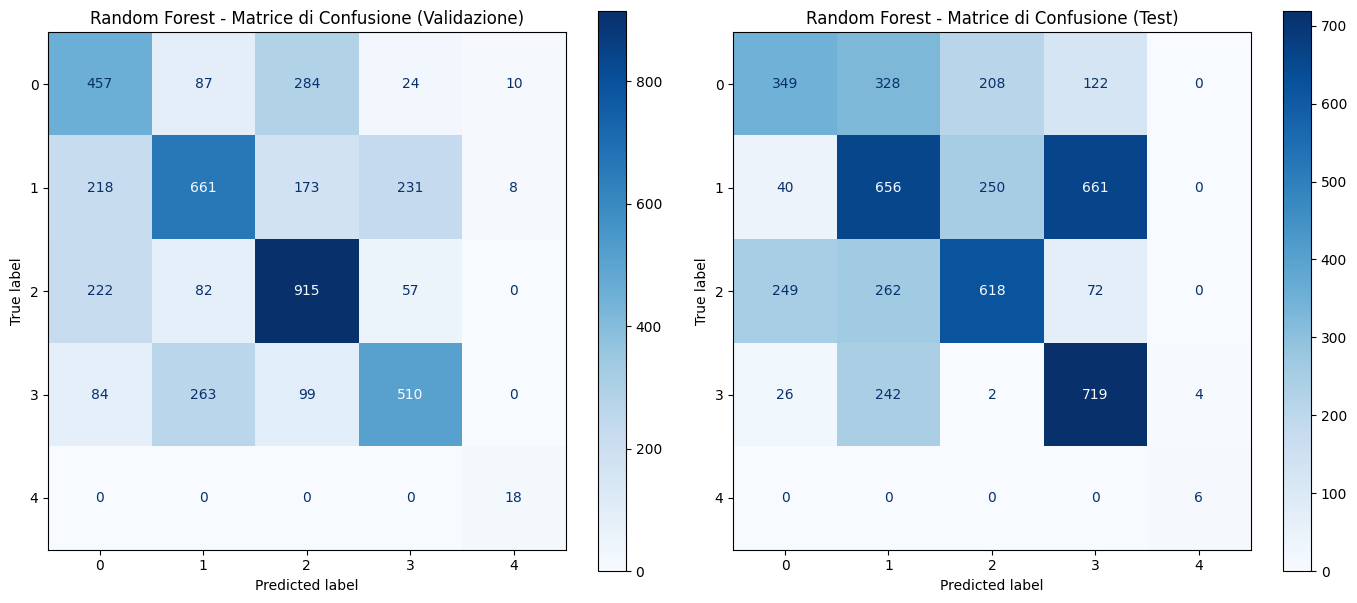

In [49]:
rf_plot_confusion_matrices(random_forest_model_exp2, X_val_imputed_exp2, y_val_encoded_exp2, X_test_imputed_exp2, y_test_encoded_exp2)

### 3.2 SVM Model

In [50]:
svm_model_exp2 = train_svm_multiclass(X_train_resampled_exp2, y_train_resampled_exp2, X_val_imputed_exp2, y_val_encoded_exp2, X_test_imputed_exp2, y_test_encoded_exp2)

Distribuzione delle classi reali nel set di validazione: [ 862 1291 1276  956   18]
Distribuzione delle classi predette nel set di validazione: [1053  635  955 1728   32]
Report di classificazione del set di validazione:
              precision    recall  f1-score   support

           0       0.22      0.27      0.25       862
           1       0.39      0.19      0.26      1291
           2       0.54      0.41      0.47      1276
           3       0.38      0.68      0.49       956
           4       0.09      0.17      0.12        18

    accuracy                           0.38      4403
   macro avg       0.33      0.34      0.32      4403
weighted avg       0.40      0.38      0.37      4403

Accuratezza sul set di validazione: 0.3770
Distribuzione delle classi reali nel set di test: [1007 1607 1201  993    6]
Distribuzione delle classi predette nel set di test: [1037 1044 1149 1507   77]
Report di classificazione del set di test:
              precision    recall  f1-score   s

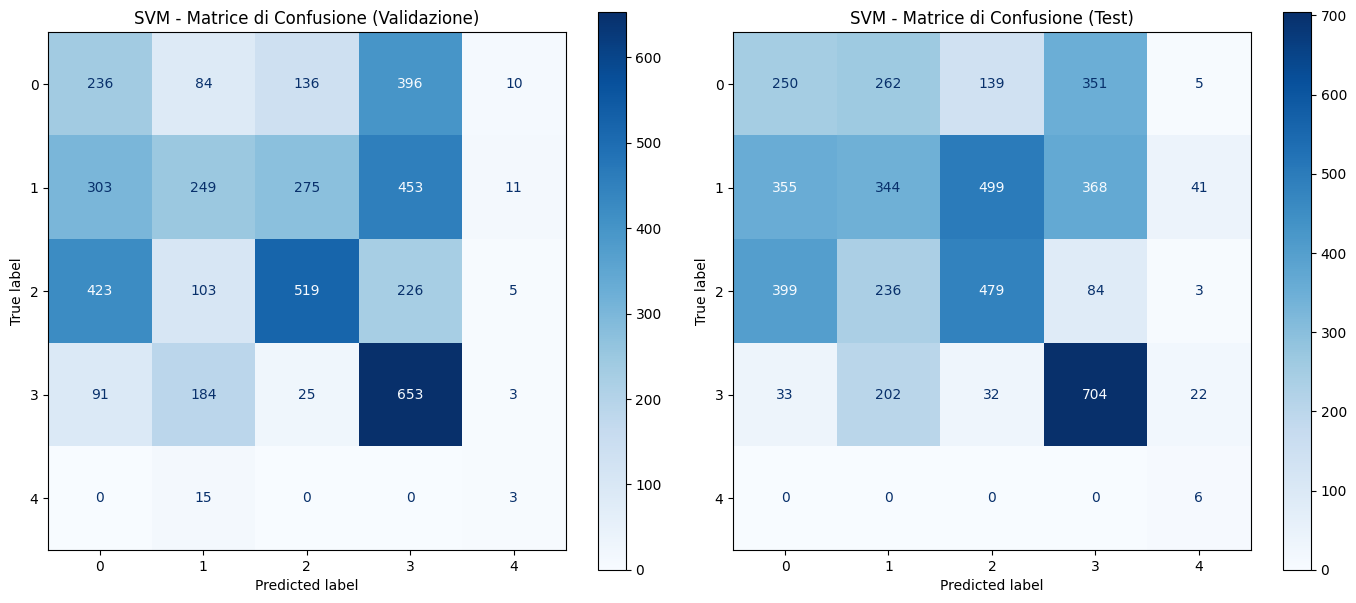

In [51]:
svm_plot_confusion_matrices(svm_model_exp2, X_val_imputed_exp2, y_val_encoded_exp2, X_test_imputed_exp2, y_test_encoded_exp2)

### 3.3 LightGBM Model

In [52]:
lightgbm_model_exp2 = train_lightgbm(X_train_resampled_exp2, y_train_resampled_exp2, X_val_imputed_exp2, y_val_encoded_exp2, X_test_imputed_exp2, y_test_encoded_exp2)

Dimensioni dopo NaN nel set di addestramento: X_train: (44150, 28), y_train: (44150,)
Dimensioni dopo NaN nel set di validazione: X_val: (4403, 28), y_val: (4403,)
Dimensioni dopo NaN nel set di test: X_test: (4814, 28), y_test: (4814,)
Classi nel set di addestramento: [0 1 2 3 4]
Classi nel set di validazione: [0 1 2 3 4]
Classi nel set di test: [0 1 2 3 4]
Report di classificazione del set di validazione:
              precision    recall  f1-score   support

           0       0.44      0.52      0.48       862
           1       0.50      0.45      0.47      1291
           2       0.56      0.64      0.60      1276
           3       0.69      0.51      0.58       956
           4       0.75      1.00      0.86        18

    accuracy                           0.54      4403
   macro avg       0.59      0.63      0.60      4403
weighted avg       0.55      0.54      0.54      4403

Accuratezza sul set di validazione: 0.5358
Report di classificazione del set di test:
              

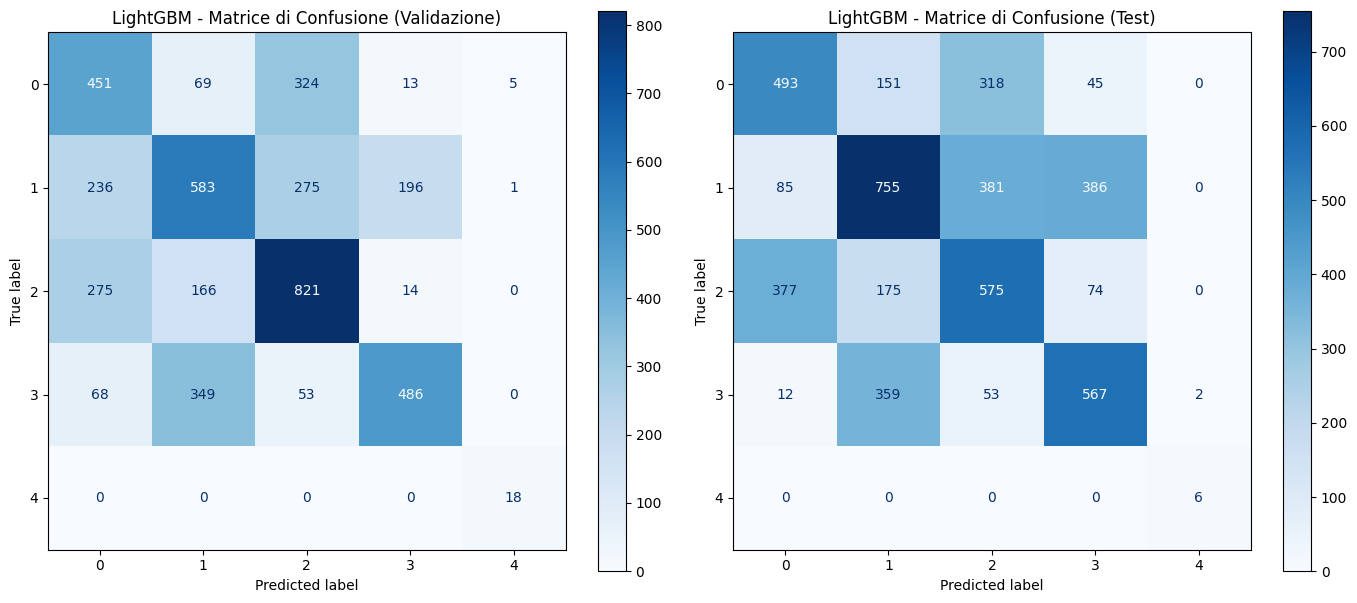

In [53]:
lightgbm_plot_confusion_matrices(lightgbm_model_exp2, X_val_imputed_exp2, y_val_encoded_exp2, X_test_imputed_exp2, y_test_encoded_exp2)